In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [11]:
#Print head of cleaned dataset
DatabaseDF = pd.read_csv("../CleanedDataset.csv")
DatabaseDF.head()

,Unnamed: 0,Operator,Well Name,Formation,Lateral Length,Stages,Township,Range,Section,"Total Prop, lbs",...,Fluid Type from DI,SPACING_CAPPED,12 month Cum Prod,Completion Type,Sleeves,P&P,Frac Ports,Repeater Ports,CT,Year Drilled
0,0,Operator 1,Well 1,MBH,5114.0,30.0,141,99,10,0.0,...,NaN,660.0,33.55,NaN,NaN,NaN,NaN,NaN,NaN,2006.0
1,1,Operator 2,Well 2,MBH,5181.0,NaN,142,99,16,418000.0,...,NaN,660.0,27.62,NaN,NaN,NaN,NaN,NaN,NaN,2005.0
2,2,Operator 2,Well 3,MBH,4780.0,15.0,142,99,24,568407.0,...,NaN,660.0,11.19,OH,NaN,NaN,NaN,NaN,NaN,2006.0
3,3,Operator 1,Well 4,MBH,10654.0,1.0,142,99,1,845000.0,...,NaN,660.0,27.85,NaN,NaN,NaN,NaN,NaN,NaN,2007.0
4,4,Operator 2,Well 5,MBH,5209.0,1.0,142,99,35,297366.0,...,NaN,660.0,50.88,OH,NaN,NaN,NaN,NaN,NaN,2006.0


# Model Definition: Pareto Chart

A Pareto Chart is a combination of a bar graph and line graph used in Economics and Business that shows the influence that various (independent) categorical variables have on a continuous (dependent) variable in the dataset. The bars are ordered such that the most frequent or prominent independent variable is on the left and the least significant variable is on the right. The line graph represent the cumulative percentages of the dependent variable and how each independent variable contributes to that percentage.

This model is more of a tool that helps analyze different features and which of them should be prioritized; it is not used for estimating a value. Pareto Charts are good if you want to narrow down the features to find the most frequent/prominent  ones, so that you can focus on the ones that are the most impactful for the final product or for a certain variable.

A Pareto Chart can be applied to oil because it can be help us narrow down certain variables by seeing which ones affect cumulative oil production the most. From there, we can decide how to distribute resources in order to maximize production. 

## More information about the ANOVA correlation and interpretation of results towards the end of the notebook.

# Plotting completion and formation types and their counts simply to visualize the data.

In [18]:

DatabaseDF['Completion Type'].value_counts(dropna = False)

P & P                            4845
Sleeves                          4250
OH                                687
NaN                               658
Sleeves and P & P                 360
Cemented Liner                     18
CT                                 14
Frac Ports                          7
Frac Ports and P & P                7
Frac Ports and Repeater Ports       3
Screen                              2
Repeater Ports and P & P            2
Perforated Liner                    2
P & P and CT                        1
Name: Completion Type, dtype: int64

In [19]:
#Function to plot pareto chart
def pareto_plot(x , counts, xlabel = "x-axis", ylabel = 'Counts', show_pct_y=False, pct_format='{0:.0%}'):

    if (type(x) != 'str'):
        x = x.astype(str)

    weights = counts/counts.sum()
    cumsum = weights.cumsum()
    
    fig, ax1 = plt.subplots(figsize = (15,10))
    ax1.bar(x, counts)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    plt.xticks(rotation = 25)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    plt.ylim(bottom = 0)
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]), fontweight='heavy')    
    
    if xlabel is not "x-axis":
        plt.title(xlabel + " Pareto Chart")
    
    plt.tight_layout()
    plt.show()

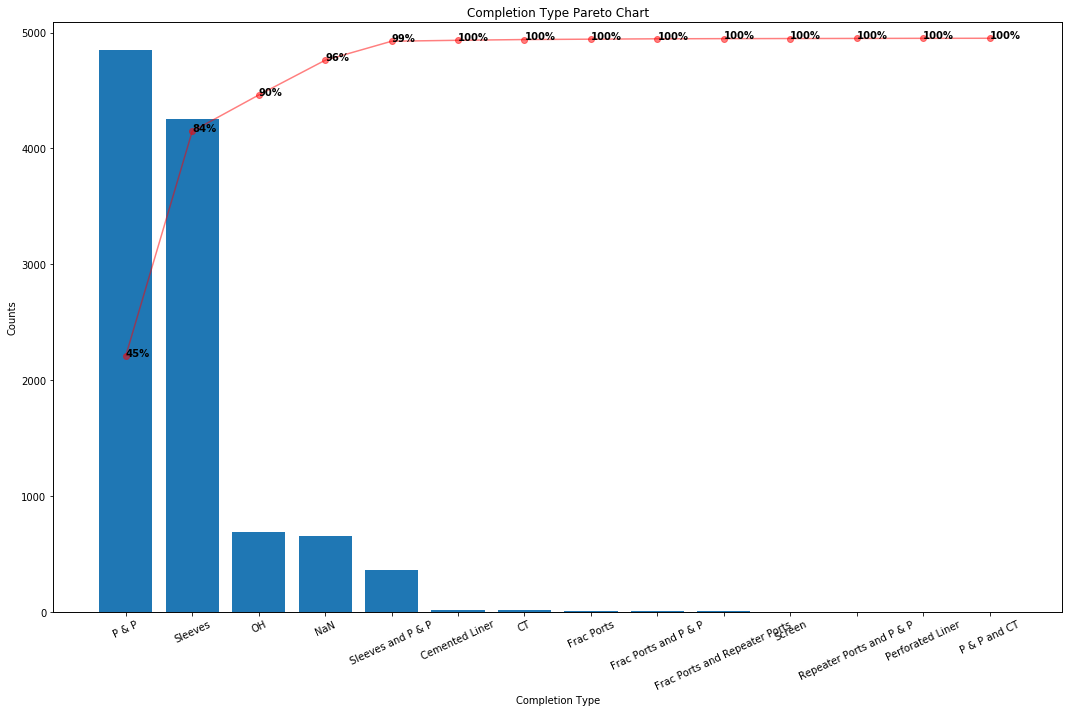

In [20]:
#Plot pareto chart for each completion type and its counts
valuesSeries = DatabaseDF['Completion Type'].fillna('NaN').value_counts()

pareto_plot(x = valuesSeries.index, counts = valuesSeries.values, xlabel = 'Completion Type')

The P&P and Sleeves completion types seem to be the most frequent in the dataset, where P&P accounts for 45% of the completions and Sleeves accounts for 39% of the completions.

In [21]:
DatabaseDF['Formation'].value_counts(dropna = False)

MBH        7065
TFH        3576
TF2          82
MBH/TFH      58
TF1          33
TF3          16
NaN           8
UTFH          6
MTFH          4
TFSH          4
TF4           2
TF2.5         2
Name: Formation, dtype: int64

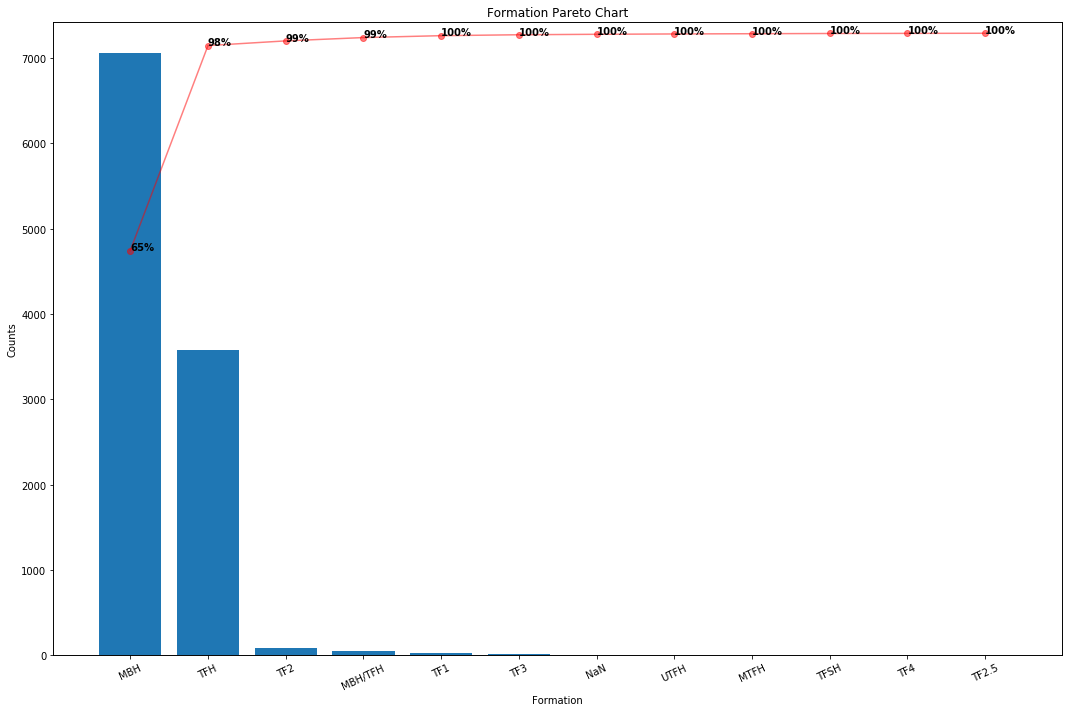

In [52]:
#Plot pareto chart for each completion type and its counts
valuesSeries = DatabaseDF['Formation'].fillna('NaN').value_counts()

pareto_plot(x = valuesSeries.index, counts = valuesSeries.values, xlabel = 'Formation')

The MBH and TFH formation types seem to be the most frequent in the dataset, where MBH accounts for 65% of the formations and TFH accounts for 33% of the formations.

# Plotting Pareto Chart for both the completion types and formation types and how the types affect cumulative oil production.

In [23]:
FormationProd = DatabaseDF.groupby('Formation')['12 month Cum Prod'].sum().sort_values(ascending = False)

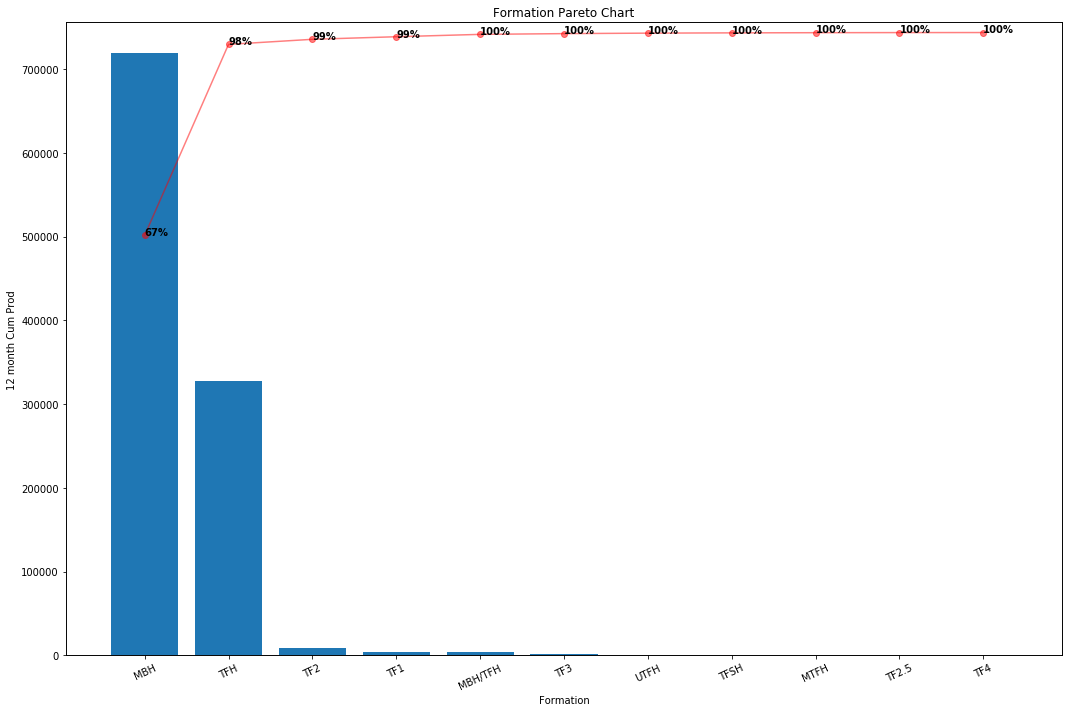

In [24]:
pareto_plot(x = FormationProd.index, counts = FormationProd.values, xlabel = 'Formation', ylabel = '12 month Cum Prod')

The MBH and TFH formation types seem to be the most impactful on oil production in the dataset, where the MBH formation is associated with 67% of the cumulative production and TFH is associated with 31% of the cumulative production.

In [25]:
ComplTypeProd = DatabaseDF.groupby('Completion Type')['12 month Cum Prod'].sum().sort_values(ascending = False)

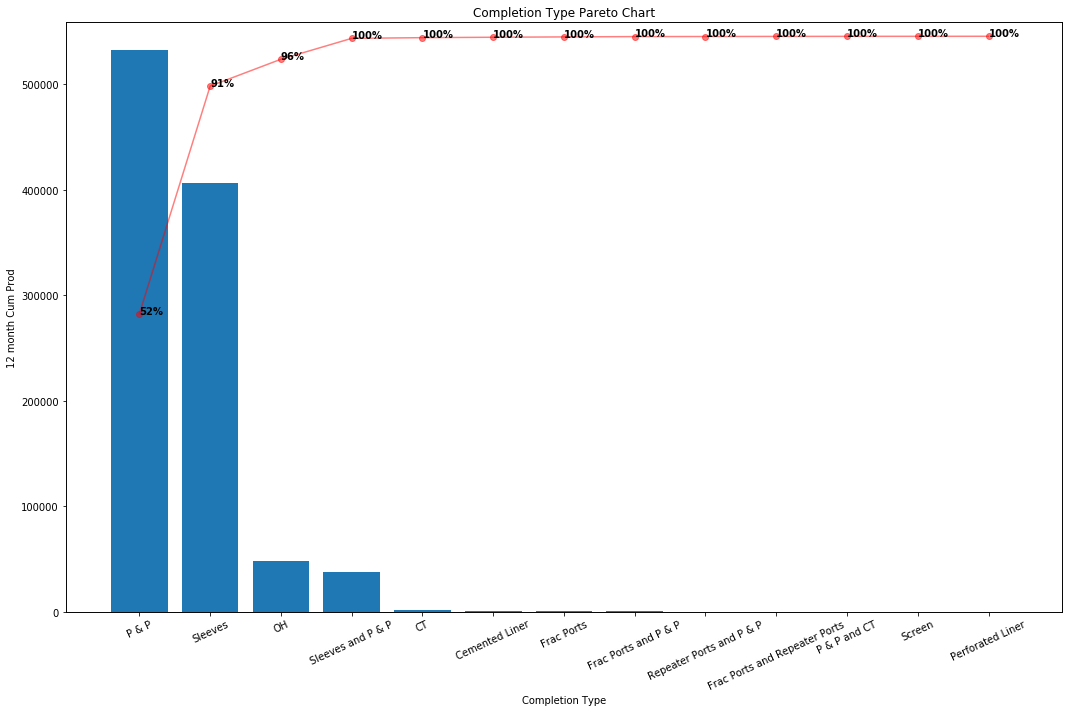

In [53]:
#Plot pareto chart for each completion type and how they are related to total oil production
pareto_plot(x = ComplTypeProd.index , counts = ComplTypeProd.values, xlabel = 'Completion Type', ylabel = '12 month Cum Prod')

The P&P and Sleeves completion types seem to be the most impactful on the oil production in the dataset, where P&P is associated with for 50% of the cumulative production and Sleeves is associated with 38% of the cumulative production.

# Plotting Fluid Type against Cumulative Oil Production.

In [27]:
FluidTypeProd = DatabaseDF.groupby('Fluid Type from DI')['12 month Cum Prod'].sum().sort_values(ascending = False)

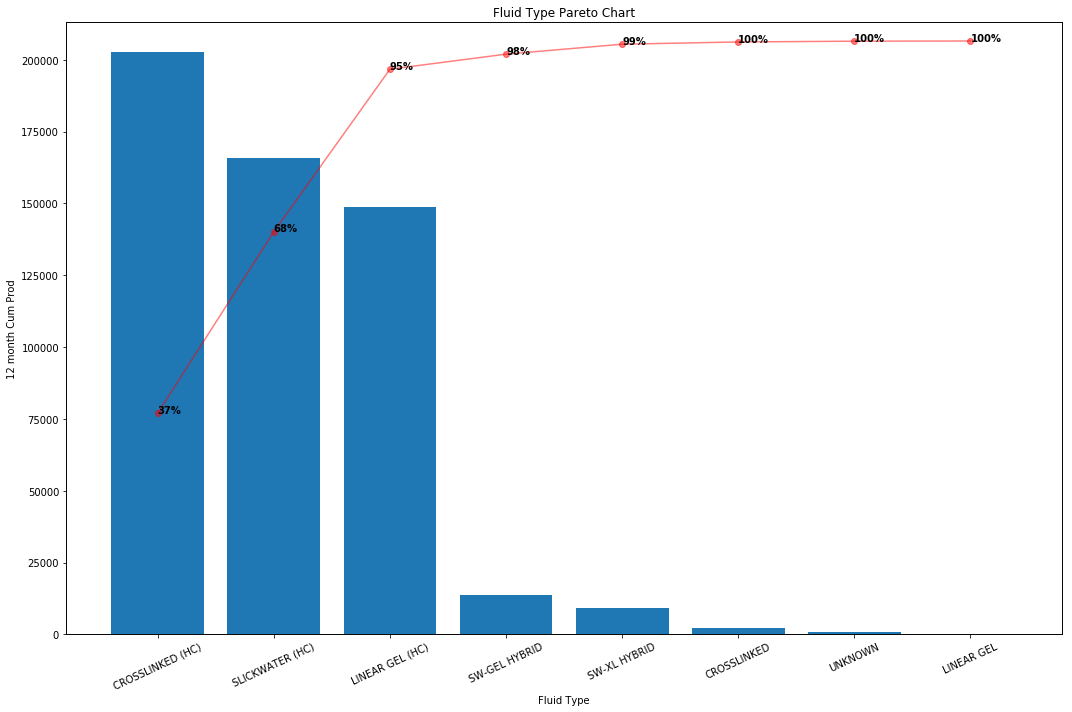

In [28]:
#Plot pareto chart for each completion type and how they are related to total oil production
pareto_plot(x = FluidTypeProd.index , counts = FluidTypeProd.values, xlabel = 'Fluid Type', ylabel = '12 month Cum Prod')

# Plotting number of stages versus oil production

In [29]:
StagesProd_unsorted = DatabaseDF.groupby('Stages')['12 month Cum Prod'].sum()

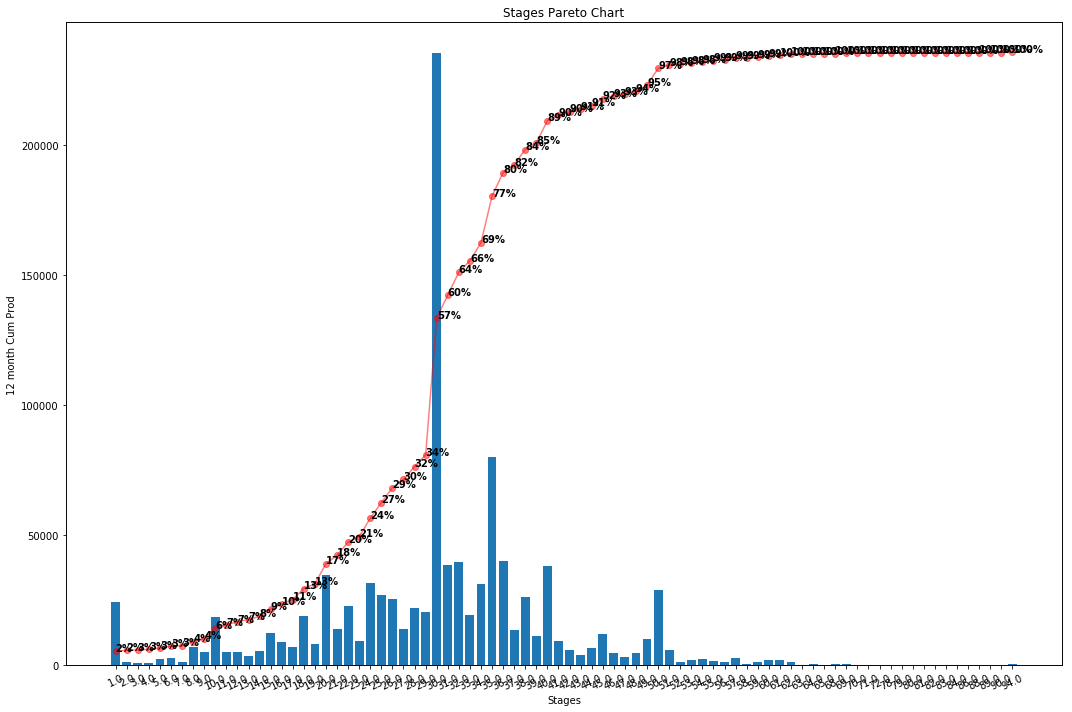

In [30]:
pareto_plot(x = StagesProd_unsorted.index , counts = StagesProd_unsorted.values, xlabel = 'Stages', ylabel = '12 month Cum Prod')

In [31]:
StagesProd = StagesProd_unsorted.sort_values(ascending = False)

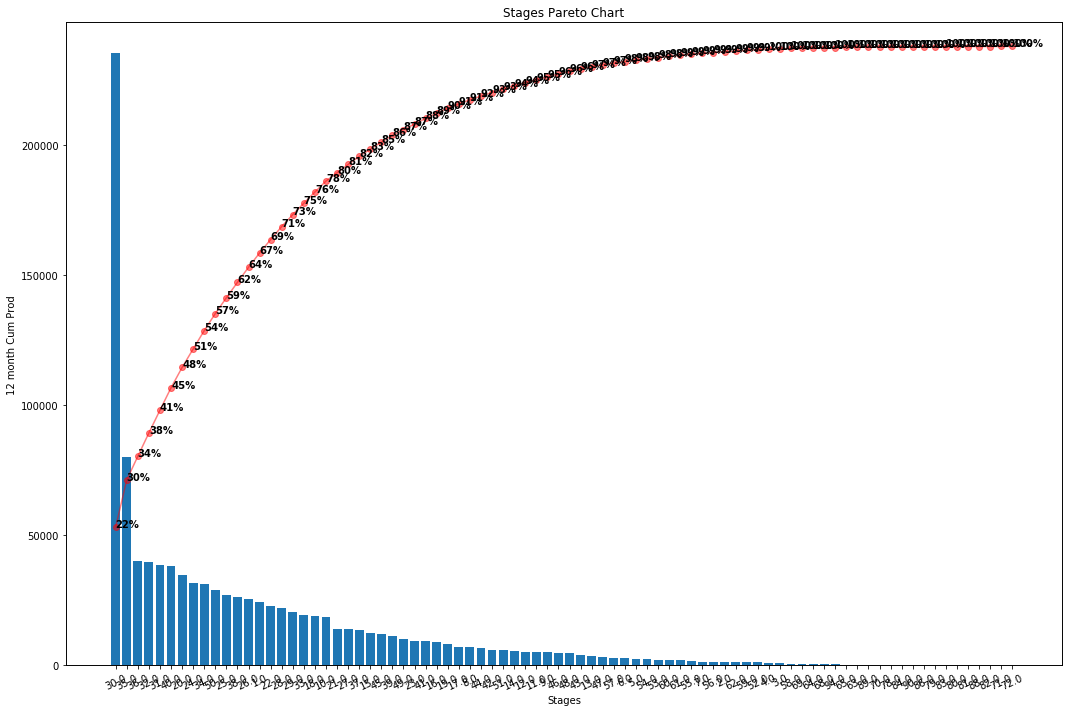

In [32]:
pareto_plot(x = StagesProd.index , counts = StagesProd.values, xlabel = 'Stages', ylabel = '12 month Cum Prod')

## Head-Tail Break Clustering Algorithm

In [33]:
#Function for head-tails break algorithm, to cluster and group data
def htb(data):
    """
    Applies the head/tail breaks algorithm to an array of data.
    Params
    ------
    data : list
        Array of data to apply ht-breaks
    Returns
    -------
    results : list 
        List of data representing break points
    """
    # test input
    assert data, "Input must not be empty."
    assert all(isinstance(datum, int) or isinstance(datum, float) for datum in data), "All input values must be numeric."

    results = []  # array of break points

    def htb_inner(data):
        """
        Inner ht breaks function for recursively computing the break points.
        """
        # Add mean to results
        data_length = float(len(data))
        data_mean = sum(data) / data_length
        results.append(data_mean)

        # Recursive call to get next break point
        head = [datum for datum in data if datum > data_mean]
        while len(head) > 1 and len(head) / data_length < 0.40:
            return htb_inner(head)

    htb_inner(data)

    return results

In [36]:
DatabaseDF['Stages'].unique()
stage_numbers = [30., 15.,  1., 18., 10.,  2.,  8.,  4., 11., 20., 39., 29.,
       27., 22., 21., 23., 35., 24., 17., 26., 40., 12., 13., 47., 28.,
       50.,  9.,  6., 36.,  5.,  7., 14., 16., 19., 38., 31., 37., 25.,
       32., 34., 33., 51., 45., 54., 43., 46.,  3., 41., 49., 44., 42.,
       48., 80., 56., 64., 69., 62., 59., 55., 94., 60., 57., 53., 65.,
       61., 52., 78., 68., 58., 82., 81., 79., 88., 84., 83., 63., 86.,
       90., 72., 89., 71., 70.]

In [37]:
#Find head-tail break value for stage numbers
htb(stage_numbers)

[42.792682926829265]

In [42]:
def oil_prod(string, feature_name):
    count = 0
    oil_production = 0
    #Calculate number rows in dataframe
    num_rows = len(DatabaseDF.index) 
    for item in range(num_rows - 1):
        if DatabaseDF.at[item, feature_name] == string:
            count += 1
            oil_production += DatabaseDF.at[item,'12 month Cum Prod']
    return oil_production

In [43]:
#Find oil production for each stage interval
interval1 = 0
interval2 = 0

for i in stage_numbers:
    if i <= 42.792682926829265:
        interval1 += (oil_prod(i, 'Stages'))
    else:
        interval2 += (oil_prod(i, 'Stages'))

In [44]:
#Create lists for pareto chart dataframe
stages_oilprod = []
stages_oilprod.append(interval1)
stages_oilprod.append(interval2)
stages_number = ['Stages 0 - 42', 'Stages 43 - 94']

In [57]:
#Create dataframe for Pareto Chart with completion types
df = pd.DataFrame({
    'Stages': stages_number,
    'Oil Production': stages_oilprod
})

In [60]:
def pareto_plot(df, x=None, y=None, title=None, show_pct_y=False, pct_format='{0:.0%}'):
    xlabel = x 
    ylabel = y 
    tmp = df.sort_values(y, ascending=False) 
    x = tmp[x].values 
    y = tmp[y].values 
    weights = y / y.sum() 
    cumsum = weights.cumsum()

    fig, ax1 = plt.subplots()
    ax1.bar(x, y)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')

    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

# hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])

    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]), fontweight='heavy')    

    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

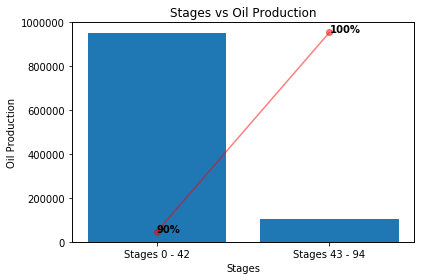

In [63]:
#Plot pareto chart for each completion type and its counts
pareto_plot(df, x='Stages', y='Oil Production', title='Stages vs Oil Production')

#Rescaling chart to reflect percentages
StageProductionDict = {}

for stage in DatabaseDF['Stages'].dropna().unique():
    validWells = DatabaseDF[DatabaseDF['Stages'].dropna() == stage]
    StageProductionDict[stage] = validWells['12 month Cum Prod'].sum()

StageProductionDict = sorted(StageProductionDict.items(), key = lambda x: x[1], reverse = True)

Stage, Production = zip(*StageProductionDict)

pareto_plot(x = pd.Series(Stage), counts = pd.Series(Production), xlabel = 'Stage', ylabel = '12 month Cum Prod')

# Plotting Year Drilled versus Oil Production.

In [18]:
YearProd_unsorted = DatabaseDF.groupby('Year Drilled')['12 month Cum Prod'].sum()

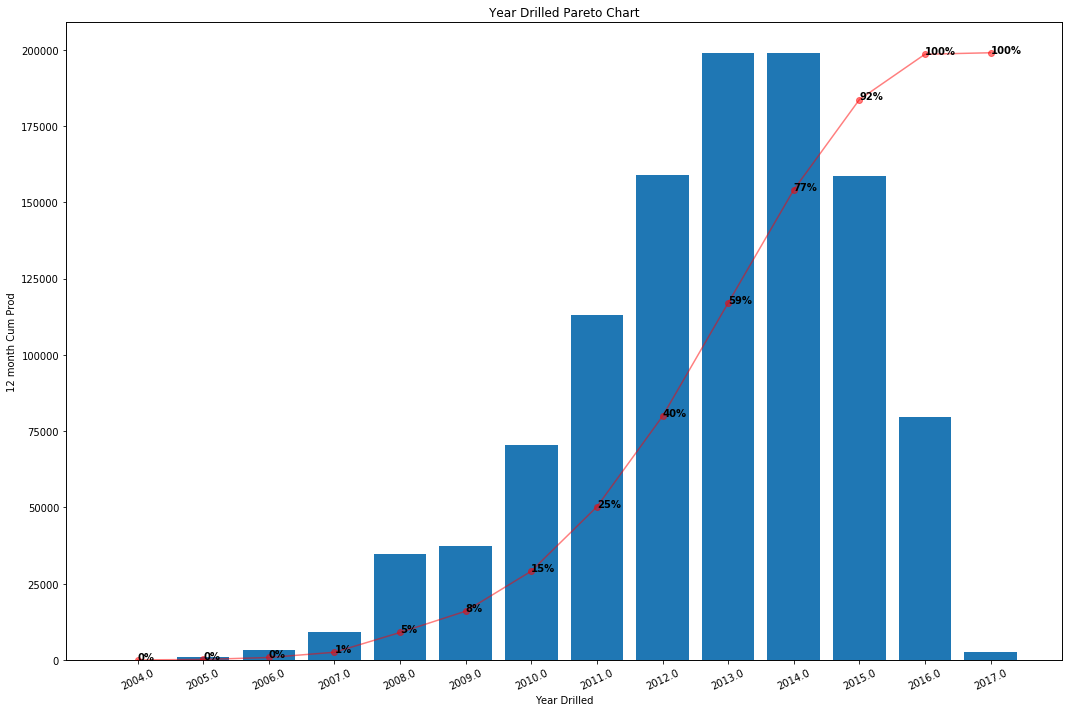

In [19]:
pareto_plot(x = YearProd_unsorted.index , counts = YearProd_unsorted.values, xlabel = 'Year Drilled', ylabel = '12 month Cum Prod')

In [20]:
YearProd = YearProd_unsorted.sort_values(ascending = False)

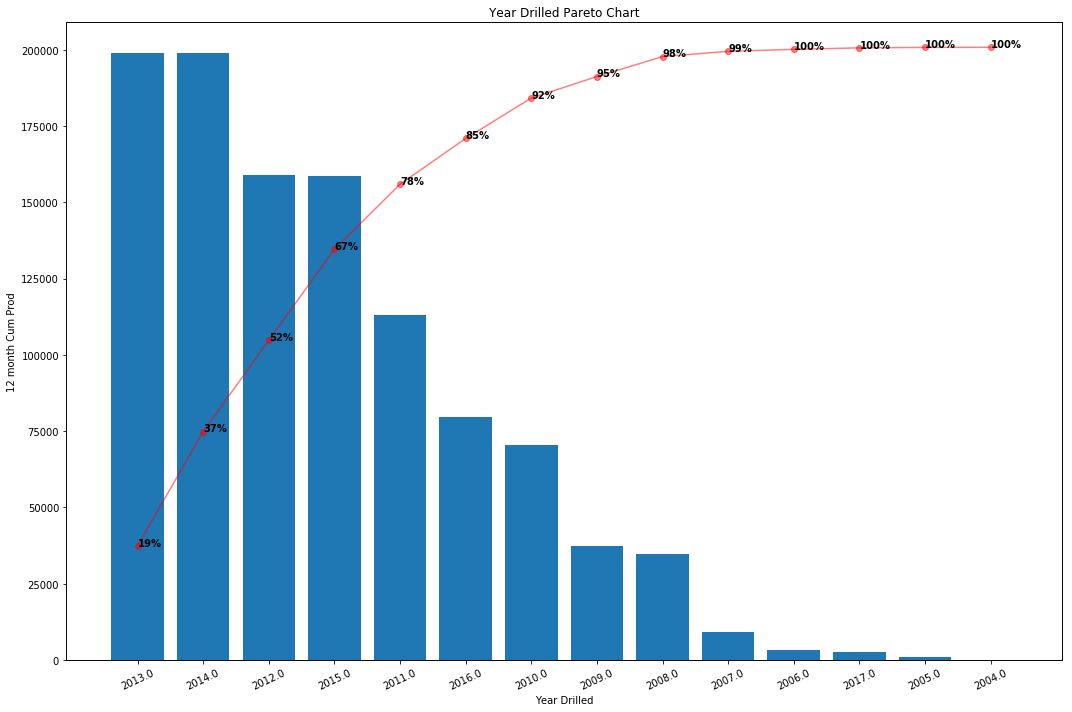

In [21]:
pareto_plot(x = YearProd.index , counts = YearProd.values, xlabel = 'Year Drilled', ylabel = '12 month Cum Prod')

# Plotting Total Proppant versus Oil Production

In [22]:
#Create bins
bins = (0, 7186141.75, 14372283.5, 21558425.25, 28744567.0)
groupnames = ['0 - 7.2M lbs', '7.2M - 14.4M lbs', '14.4M - 21.6M', '21.6M - 28.8M']
DatabaseDF['Proppant Bins'] = pd.cut(DatabaseDF['Total Prop, lbs'], bins = bins, labels = groupnames)

In [23]:
TotalProp_unsorted = DatabaseDF.groupby('Proppant Bins')['12 month Cum Prod'].sum()

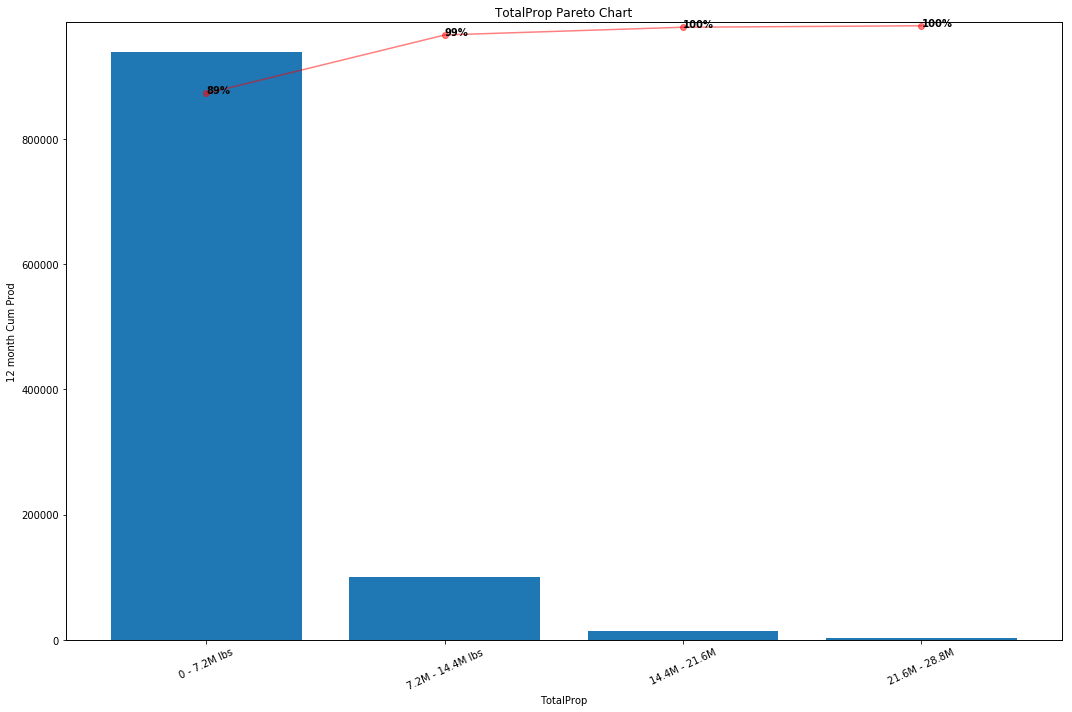

In [24]:
pareto_plot(x = TotalProp_unsorted.index , counts = TotalProp_unsorted.values, xlabel = 'TotalProp', ylabel = '12 month Cum Prod')

In [25]:
TotalProp = TotalProp_unsorted.sort_values(ascending = False)

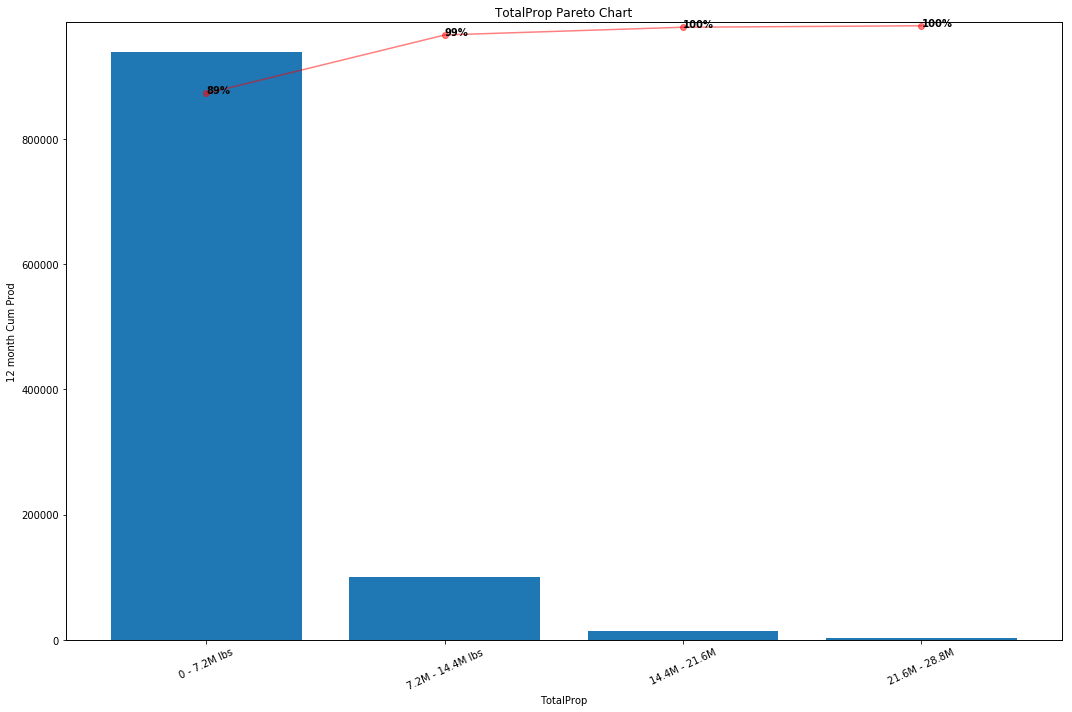

In [26]:
pareto_plot(x = TotalProp.index , counts = TotalProp.values, xlabel = 'TotalProp', ylabel = '12 month Cum Prod')

# Plotting amount of Fluid versus Oil Production

In [27]:
#Create bins
bins = (0, 149640.5, 299281.0, 448921.5 , 598562.0)
groupnames = ['0 - 150K bbls', '150K bbls - 300K bbls', '300K bbls - 450K bbls', '450K bbls- 600K bbls']
DatabaseDF['Fluid Bins'] = pd.cut(DatabaseDF['Fluid, bbls'], bins = bins, labels = groupnames)

In [28]:
FluidAmmount_unsorted = DatabaseDF.groupby('Fluid Bins')['12 month Cum Prod'].sum()

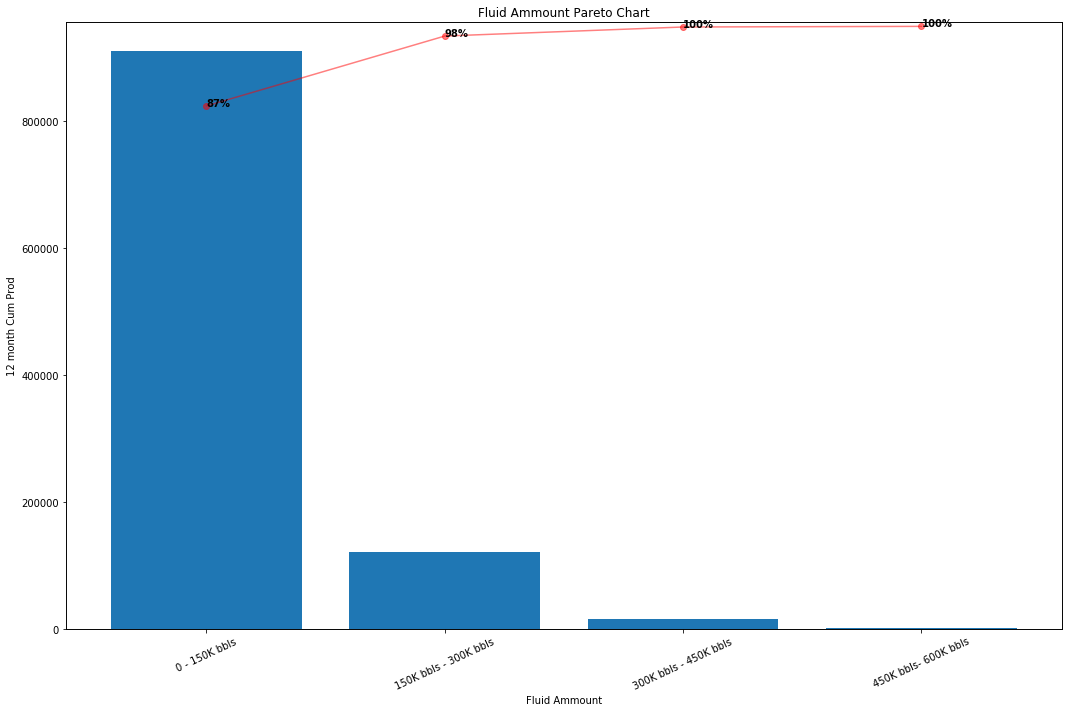

In [29]:
pareto_plot(x = FluidAmmount_unsorted.index , counts = FluidAmmount_unsorted.values, xlabel = 'Fluid Ammount', ylabel = '12 month Cum Prod')

In [30]:
FluidAmmount = FluidAmmount_unsorted.sort_values(ascending = False)

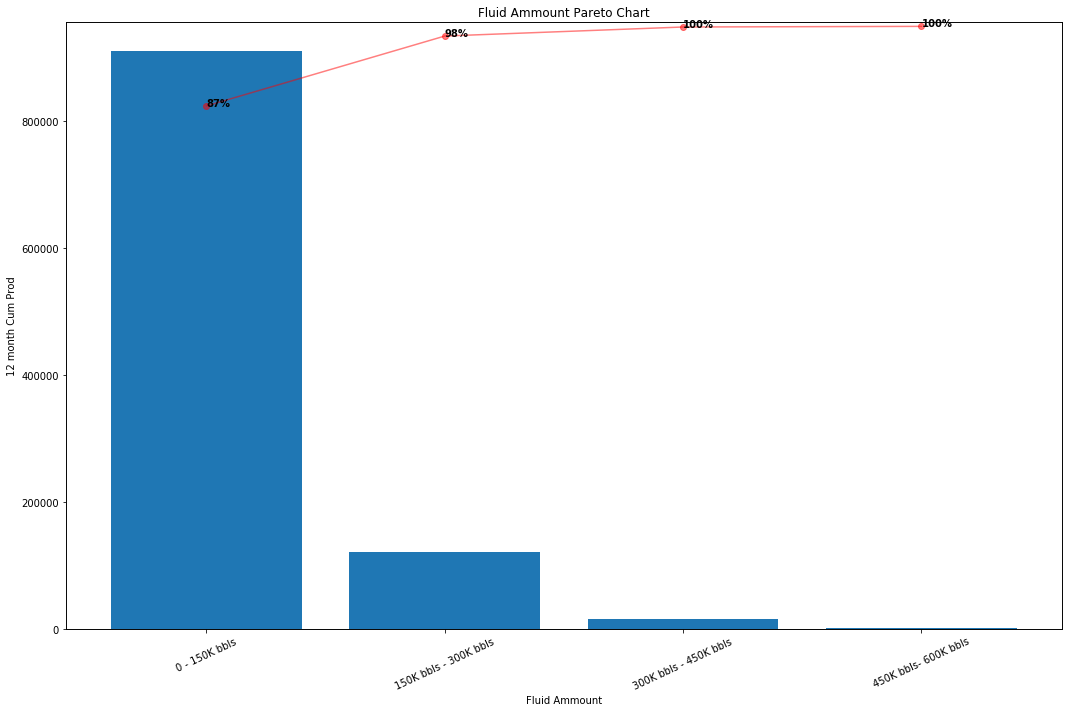

In [31]:
pareto_plot(x = FluidAmmount.index , counts = FluidAmmount.values, xlabel = 'Fluid Ammount', ylabel = '12 month Cum Prod')

# Plotting Spacing Capped versus Oil Production

In [32]:
#Create bins
bins = (18.074815, 178.55611125, 339.0374, 499.51870375, 660.0)
groupnames = ['18 - 178.6', '178.6 - 339.0', '339.0 - 500.0', '500.0 - 660.0']
DatabaseDF['Spacing Bins'] = pd.cut(DatabaseDF['SPACING_CAPPED'], bins = bins, labels = groupnames)

In [33]:
SpacingCapped_unsorted = DatabaseDF.groupby('Spacing Bins')['12 month Cum Prod'].sum()

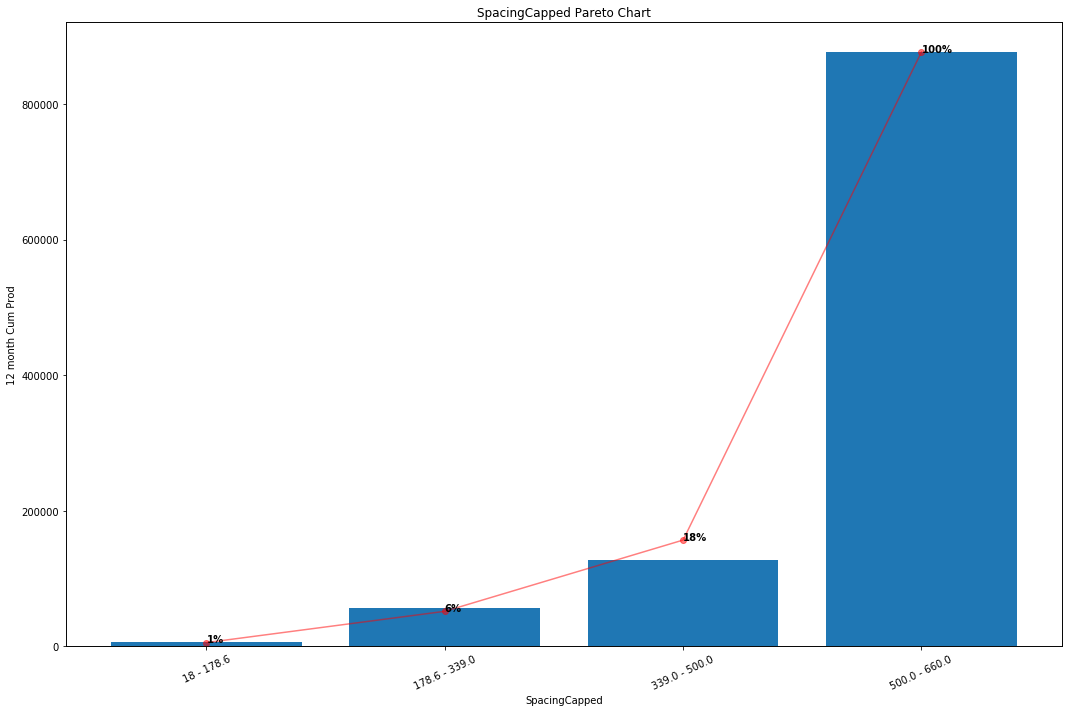

In [34]:
pareto_plot(x = SpacingCapped_unsorted.index , counts = SpacingCapped_unsorted.values, xlabel = 'SpacingCapped', ylabel = '12 month Cum Prod')

In [35]:
SpacingCapped = SpacingCapped_unsorted.sort_values(ascending = False)

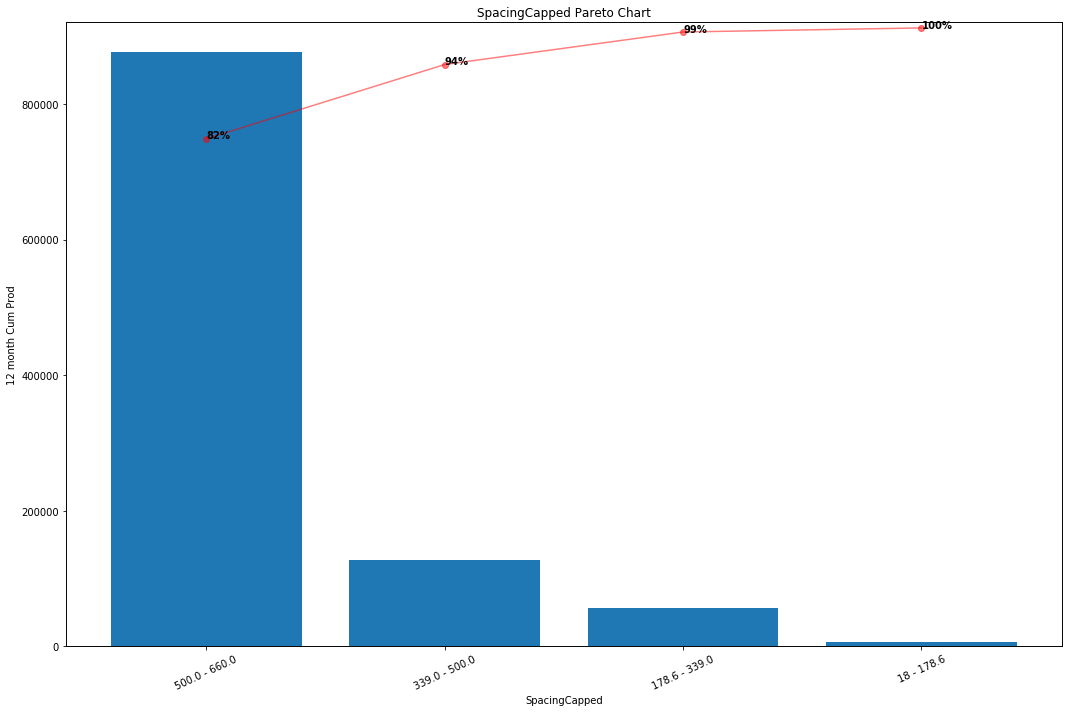

In [36]:
pareto_plot(x = SpacingCapped.index , counts = SpacingCapped.values, xlabel = 'SpacingCapped', ylabel = '12 month Cum Prod')

# Comparing all features versus oil production

In [179]:
#Create lists to compare all features and the oil production of each feature's unique component 
total_oilprod = []
label = []
total_oilprod.append(max(form_oilprod))
label.append('Formation')
total_oilprod.append(max(compl_oilprod))
label.append('Completion Type')
total_oilprod.append(max(fluid_oilprod))
label.append('Fluid Type')
total_oilprod.append(max(stages_oilprod))
label.append('Stage')
total_oilprod.append(max(year_oilprod))
label.append('Year')
total_oilprod.append(max(spacing_oilprod))
label.append('Spacing Capped')
total_oilprod.append(max(fluid_oilprod))
label.append('Fluid')
total_oilprod.append(max(prop_oilprod))
label.append('Total Proppant')

In [15]:
#Create dataframe for Pareto Chart with completion types
df = pd.DataFrame({
    'Feature': label,
    'Oil Production': total_oilprod
})

NameError: name 'label' is not defined

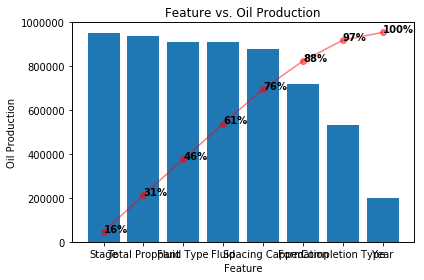

In [187]:
#Plot pareto chart for each formation type and how they are related to total oil production
pareto_plot(df, x='Feature', y='Oil Production', title= 'Feature vs. Oil Production')

This is a really good model. Of course, once we have research components figured out, I think using that of what we have learned onto this model will be beneficial

## First, the variance and confidence intervals of the oil production of each feature is calculated and plotted against each other.

### The lower the variance in the confidence interval, the better the feature is for oil production.

In [174]:
#calculate 95% confidence interval
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [156]:
#Finds confidence interval for categorical variables
def oil_prod(feature_list, feature_name):
    unique_array = []
    count = 0
    oil_production = 0
    #Calculate number rows in dataframe
    num_rows = len(DatabaseDF.index) 
    for i in feature_list:
        for item in range(num_rows - 1):
            if DatabaseDF.at[item, feature_name] == i:
                count += 1
                unique_array.append(DatabaseDF.at[item,'12 month Cum Prod'])
        return mean_confidence_interval(unique_array)

In [157]:
#lists that will store the feature names and variance values
variance_oilprod = []
features_oilprod = []

In [158]:
#prints the result of each feature
#this includes the confidence interval and the variance in oil production
def print_results_oilprod(feature_list, feature_name):
    print(feature_name, ": ", oil_prod(feature_list, feature_name))
    variance = oil_prod(feature_list, feature_name)[0] - oil_prod(feature_list, feature_name)[1]
    print("Variance", ": ", variance)
    variance_oilprod.append(variance)
    features_oilprod.append(feature_name)

In [159]:
#prints Formation results
formation_types ['MBH', 'TFH', 'MBH/TFH', 'TF2', 'TF4','TF3','UTFH','TF1','MTFH','TFSH','TF2.5']
print_results_oilprod(formation_types, 'Formation')

Formation :  (101.8378227633069, 100.53585707763811, 103.1397884489757)
Variance :  1.3019656856687902


In [160]:
#prints Completion Type results
completion_types = ['zero', 'OH', 'Sleeves', 'P & P', 'Sleeves and P & P', 'Screen',
       'Cemented Liner', 'Perforated Liner', 'Frac Ports',
       'Frac Ports and P & P', 'Frac Ports and Repeater Ports', 'CT',
       'P & P and CT', 'Repeater Ports and P & P']
print_results_oilprod(completion_types, 'Completion Type')

Completion Type :  (nan, nan, nan)
Variance :  nan


In [161]:
#prints Fluid Type results
fluid_types = ['LINEAR GEL (HC)', 'CROSSLINKED (HC)', 'SLICKWATER (HC)',
       'SW-XL HYBRID', 'CROSSLINKED', 'UNKNOWN', 'SW-GEL HYBRID',
       'LINEAR GEL']
print_results_oilprod(fluid_types, 'Fluid Type from DI')

Fluid Type from DI :  (107.7898696596669, 104.85803363120016, 110.72170568813365)
Variance :  2.9318360284667477


In [162]:
#Calculates confidence intervals for quantitative variables
def CI_bins(feature_name, min, max):
    bins_oilprod = []
    count = 0
    #oil_production = 0
    #Calculate number rows in dataframe
    num_rows = len(DatabaseDF.index) 
    for item in range(num_rows - 1):
        if DatabaseDF.at[item, feature_name] >= min and DatabaseDF.at[item, feature_name] <= max:
            count += 1
            bins_oilprod.append(DatabaseDF.at[item,'12 month Cum Prod'])
    return mean_confidence_interval(bins_oilprod)

In [163]:
#Prints Stages results 
print("Stages: ", oil_prod(stage_numbers, 'Stages'))
variance = oil_prod(stage_numbers, 'Stages')[0] - oil_prod(stage_numbers, 'Stages')[1]
print("Variance", ": ", variance)
variance_oilprod.append(variance)
features_oilprod.append('Stages')

Stages:  (96.6392531801395, 94.91766007332893, 98.36084628695008)
Variance :  1.7215931068105732


In [164]:
#Prints Year Drilled results
print("Year Drilled: ", oil_prod(year_drilled, 'Year Drilled'))
variance = oil_prod(year_drilled, 'Year Drilled')[0] - oil_prod(year_drilled, 'Year Drilled')[1]
print("Variance", ": ", variance)
variance_oilprod.append(variance)
features_oilprod.append('Year Drilled')

Year Drilled:  (44.029487179487184, 33.55511512321959, 54.503859235754774)
Variance :  10.47437205626759


In [165]:
#Prints Proppant results
print("Total Prop, lbs: ", oil_prod(proppant_intervals, 'Total Prop, lbs'))
variance = oil_prod(proppant_intervals, 'Total Prop, lbs')[0] - oil_prod(proppant_intervals, 'Total Prop, lbs')[1]
print("Variance", ": ", variance)
variance_oilprod.append(variance)
features_oilprod.append('Total Prop, lbs')

Total Prop, lbs:  (91.56125874125873, 82.24044062707937, 100.88207685543809)
Variance :  9.32081811417936


In [166]:
#Prints Fluid results
print("Fluid, bbls: ", oil_prod(fluid_intervals, 'Fluid, bbls'))
variance = oil_prod(fluid_intervals, 'Fluid, bbls')[0] - oil_prod(fluid_intervals, 'Fluid, bbls')[1]
print("Variance", ": ", variance)
variance_oilprod.append(variance)
features_oilprod.append('Fluid, bbls')

Fluid, bbls:  (25.633333333333336, 5.782565200305491, 45.48410146636118)
Variance :  19.850768133027845


In [167]:
#Prints Spacing Capped results
print("SPACING_CAPPED ", oil_prod(spacing_capped, 'SPACING_CAPPED'))
variance = oil_prod(spacing_capped, 'SPACING_CAPPED')[0] - oil_prod(spacing_capped, 'SPACING_CAPPED')[1]
print("Variance", ": ", variance)
variance_oilprod.append(variance)
features_oilprod.append('SPACING_CAPPED')

SPACING_CAPPED  (88.63359467455622, 87.25705993706099, 90.01012941205146)
Variance :  1.3765347374952341


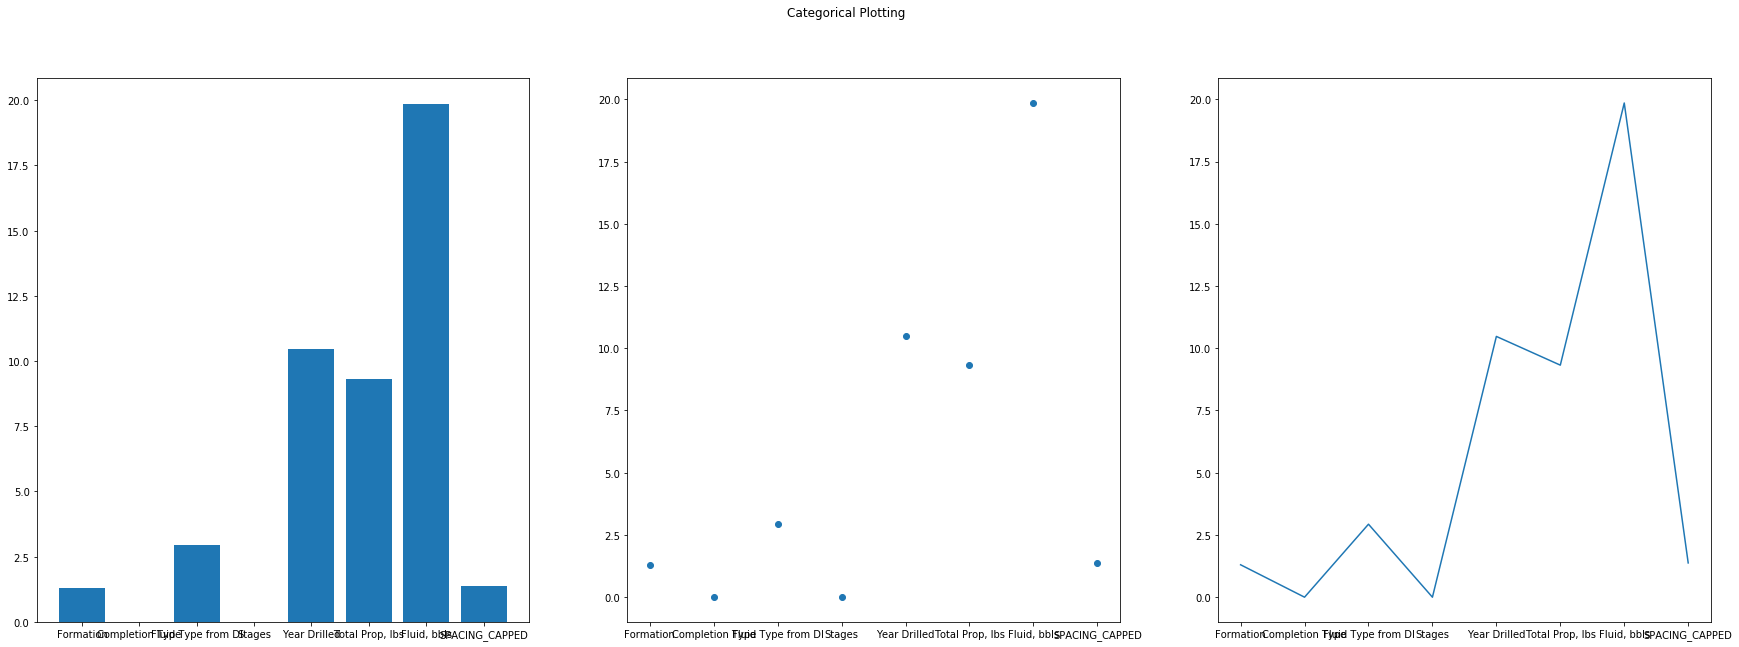

In [171]:
#Prints comparison of variance values for oil production
names = features_oilprod
values = variance_oilprod
plt.figure(figsize=(30, 10))

plt.subplot(131)
plt.bar(names, values)
plt.subplot(132)
plt.scatter(names, value
s)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Categorical Plotting')
plt.show()

feature_count = []
def conf_interval(string, feature_name):
    count = 0
    #oil_production = 0
    #Calculate number rows in dataframe
    num_rows = len(DatabaseDF.index) 
    for item in range(num_rows - 1):
        if DatabaseDF.at[item, feature_name] == string:
            count += 1
            array2.append(DatabaseDF.at[item,'12 month Cum Prod'])
    return mean_confidence_interval(array2)

## Now, the confidence interval and variance for the counts of each feature is calculated and plotted.

In [26]:
#count frequency of each unique element in feature
def count_freq(compare, feature_name):
    count = 0
    for item in DatabaseDF[feature_name]:
        if item == compare:
            count = count + 1
    return count

In [27]:
#Calculates confidence interval of counts
def count_unique(feature_list, feature_name):
    unique_counts = []
    count = 0
    for item in feature_list:
        unique_counts.append(count_freq(item, feature_name))
        count = count + 1
    return mean_confidence_interval(unique_counts)

In [79]:
#lists that will store the feature names and variance values
feature_names = []
variance_values = []

In [80]:
#Prints confidence interval and variance value
def print_results(feature_list, feature_name):
    print(feature_name, ": ", count_unique(feature_list, feature_name))
    variance = count_unique(feature_list, feature_name)[0] - count_unique(feature_list, feature_name)[1]
    print("Variance", ": ", variance)
    variance_values.append(variance)
    feature_names.append(feature_name)

In [81]:
#Calculates results for formation types
formation_types = ['MBH', 'TFH', 'MBH/TFH', 'TF2', 'TF4', 'TF3','UTFH', 'TF1','MTFH', 'TFSH', 'TF2.5']
print_results(formation_types, 'Formation')

Formation :  (986.1818181818181, -546.0057011750424, 2518.369337538679)
Variance :  1532.1875193568605


In [82]:
#Calculates results for completion types
completion_types = ['zero', 'OH', 'Sleeves', 'P & P', 'Sleeves and P & P', 'Screen',
       'Cemented Liner', 'Perforated Liner', 'Frac Ports',
       'Frac Ports and P & P', 'Frac Ports and Repeater Ports', 'CT',
       'P & P and CT', 'Repeater Ports and P & P']
print_results(completion_types, 'Completion Type')

Completion Type :  (728.4285714285714, -215.02569622178737, 1671.8828390789304)
Variance :  943.4542676503588


In [83]:
#Calculates results for fluid type 
fluid_types = ['LINEAR GEL (HC)', 'CROSSLINKED (HC)', 'SLICKWATER (HC)',
       'SW-XL HYBRID', 'CROSSLINKED', 'UNKNOWN', 'SW-GEL HYBRID',
       'LINEAR GEL']
print_results(fluid_types, 'Fluid Type from DI')

Fluid Type from DI :  (635.0, -59.085408036225544, 1329.0854080362255)
Variance :  694.0854080362255


In [84]:
#Calculates results for stage numbers
stage_numbers = [30., 15.,  1., 18., 10.,  2.,  8.,  4., 11., 20., 39., 29.,
       27., 22., 21., 23., 35., 24., 17., 26., 40., 12., 13., 47., 28.,
       50.,  9.,  6., 36.,  5.,  7., 14., 16., 19., 38., 31., 37., 25.,
       32., 34., 33., 51., 45., 54., 43., 46.,  3., 41., 49., 44., 42.,
       48., 80., 56., 64., 69., 62., 59., 55., 94., 60., 57., 53., 65.,
       61., 52., 78., 68., 58., 82., 81., 79., 88., 84., 83., 63., 86.,
       90., 72., 89., 71., 70.]
print_results(stage_numbers, 'Stages')

Stages :  (130.34146341463415, 65.91776141176427, 194.76516541750402)
Variance :  64.42370200286987


In [85]:
#Calculates results for year drilled
year_drilled = [2006., 2005., 2007., 2008., 2004., 2009., 2011., 2012., 2010.,
       2013., 2014., 2016., 2015., 2017.]
print_results(year_drilled, 'Year Drilled')

Year Drilled :  (774.8571428571429, 341.4832200320706, 1208.231065682215)
Variance :  433.37392282507227


In [86]:
#Calculates results for spacing capped
spacing_capped = []
for i in DatabaseDF['SPACING_CAPPED'].unique():
    spacing_capped.append(i)
#count_unique(spacing_capped, 'SPACING_CAPPED')  
print_results(spacing_capped, 'SPACING_CAPPED')

SPACING_CAPPED :  (2.588782816229117, -0.2579189595525051, 5.435484592010739)
Variance :  2.846701775781622


In [87]:
#Calculates results for fluid
fluid_intervals = []
for i in DatabaseDF['Fluid, bbls'].unique():
    fluid_intervals.append(i)
#count_unique(fluid_intervals, 'Fluid, bbls')
print_results(fluid_intervals, 'Fluid, bbls')

Fluid, bbls :  (1.0706242591860924, 1.0279852958104398, 1.113263222561745)
Variance :  0.04263896337565254


In [88]:
#Calculates results for total proppant
proppant_intervals = []
for i in DatabaseDF['Total Prop, lbs'].unique():
    proppant_intervals.append(i)
count_unique(proppant_intervals, 'Total Prop, lbs')
print_results(proppant_intervals, 'Total Prop, lbs')

Total Prop, lbs :  (1.0360755869440732, 1.0092913669392334, 1.062859806948913)
Variance :  0.02678422000483982


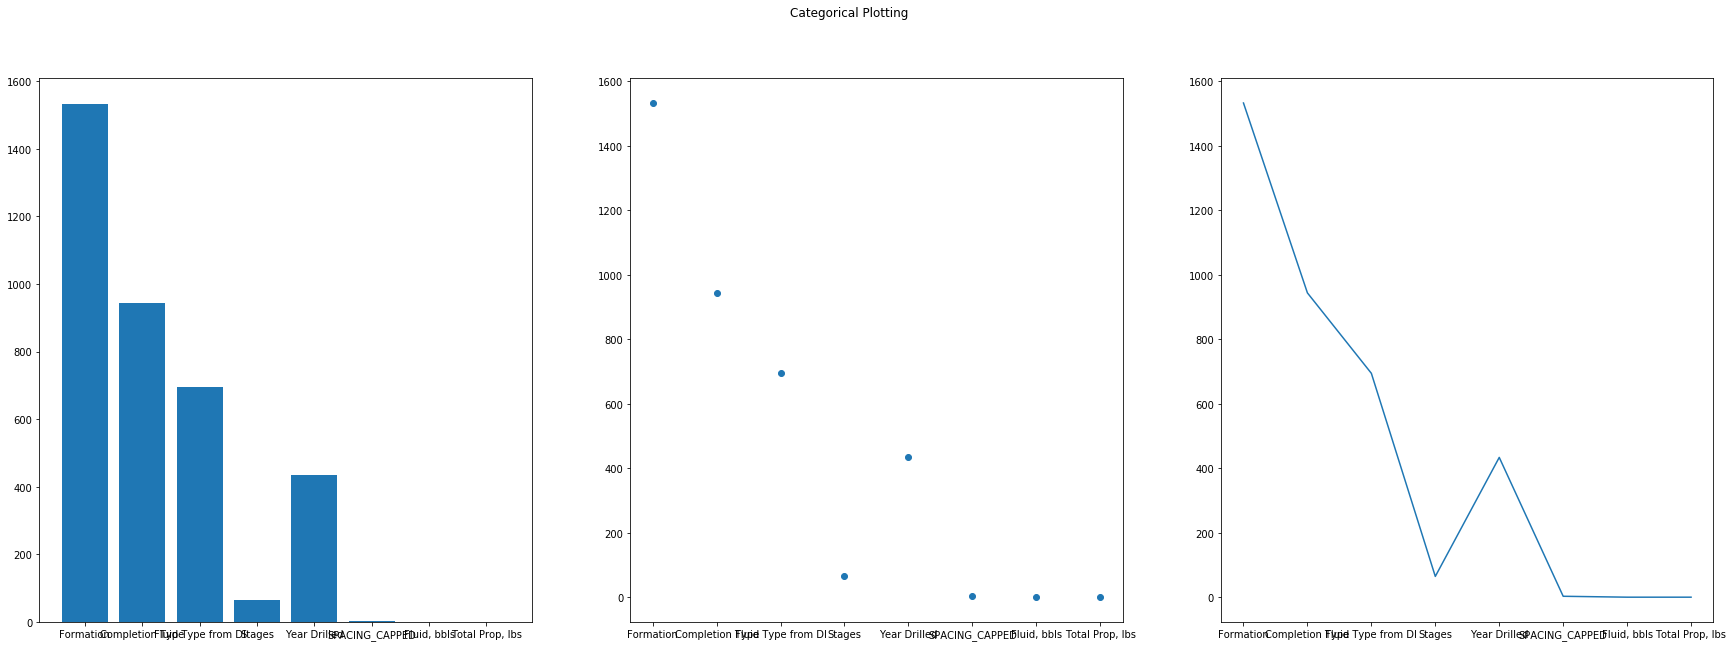

In [89]:
#Prints comparison of variances for counts
names = feature_names
values = variance_values

plt.figure(figsize=(30, 10))

plt.subplot(131)
plt.bar(names, values)
plt.subplot(132)
plt.scatter(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Categorical Plotting')
plt.show()